In [12]:
#======================================================================
#  Cell 1 — Setup (paths, device, imports)
#======================================================================

import os, cv2, glob, gc, math, time, json, random
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# --------- PATHS ----------
AVENUE_ROOT = "/kaggle/input/weapon-dataset/Avenue_Dataset/Avenue Dataset"
TRAIN_VIDS  = os.path.join(AVENUE_ROOT, "training_videos")
TEST_VIDS   = os.path.join(AVENUE_ROOT, "testing_videos")

WORK        = "/kaggle/working/unsup_anomaly"
FR_TRAIN    = os.path.join(WORK, "frames/train")
FR_TEST     = os.path.join(WORK, "frames/test")
OUT_DIR     = os.path.join(WORK, "outputs")
os.makedirs(FR_TRAIN, exist_ok=True)
os.makedirs(FR_TEST, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("Train vids:", len(os.listdir(TRAIN_VIDS)))
print("Test  vids:", len(os.listdir(TEST_VIDS)))


Device: cuda
Train vids: 16
Test  vids: 21


In [13]:
#======================================================================
# Cell 2 — Extract frames (skip if already done)
#======================================================================

def extract_frames(video_dir, out_dir, resize=(224, 224)):
    os.makedirs(out_dir, exist_ok=True)
    vids = sorted([f for f in os.listdir(video_dir) if f.lower().endswith((".avi",".mp4",".mov"))])
    total = 0
    for v in tqdm(vids, desc=f"Extracting from {os.path.basename(video_dir)}"):
        path = os.path.join(video_dir, v)
        base = os.path.splitext(v)[0]
        cap = cv2.VideoCapture(path)
        i = 0
        while True:
            ok, frame = cap.read()
            if not ok: break
            if resize is not None:
                frame = cv2.resize(frame, resize, interpolation=cv2.INTER_AREA)
            cv2.imwrite(os.path.join(out_dir, f"{base}_{i:05d}.jpg"), frame)
            i += 1; total += 1
        cap.release()
    print(f"✅ Saved {total} frames to {out_dir}")

# Run once; if you already extracted earlier, you can skip.
if len(os.listdir(FR_TRAIN)) < 100:
    extract_frames(TRAIN_VIDS, FR_TRAIN)
if len(os.listdir(FR_TEST)) < 100:
    extract_frames(TEST_VIDS, FR_TEST)

print("Train frames:", len([f for f in os.listdir(FR_TRAIN) if f.endswith('.jpg')]))
print("Test  frames:", len([f for f in os.listdir(FR_TEST) if f.endswith('.jpg')]))


Extracting from training_videos: 100%|██████████| 16/16 [00:32<00:00,  2.02s/it]


✅ Saved 15328 frames to /kaggle/working/unsup_anomaly/frames/train


Extracting from testing_videos: 100%|██████████| 21/21 [00:33<00:00,  1.59s/it]

✅ Saved 15324 frames to /kaggle/working/unsup_anomaly/frames/test
Train frames: 15328
Test  frames: 15324


In [14]:
#======================================================================
# Cell 3 — Dataset: motion-difference stacks (temporal K)
#======================================================================

class DiffStackDataset(Dataset):
    """
    Creates K-length stacks of |gray_t - gray_(t-1)| as channels.
    Each sample corresponds to a clip centered at index t.
    """
    def __init__(self, frames_dir, K=5, stride=1, split="train"):
        self.paths = sorted([os.path.join(frames_dir, f) for f in os.listdir(frames_dir) if f.endswith(".jpg")])
        self.K = K
        self.stride = stride
        self.split = split
        # build indices (we need t-K..t-1 diffs to reach t)
        self.valid_idx = list(range(K, len(self.paths)))
    def __len__(self):
        return len(self.valid_idx)
    def __getitem__(self, i):
        t = self.valid_idx[i]
        # load frames t-K..t
        ims = []
        for idx in range(t - self.K, t + 1):
            img = cv2.imread(self.paths[idx])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = img.astype(np.float32) / 255.0
            ims.append(img)
        ims = np.stack(ims, 0)  # (K+1,H,W)
        diffs = np.abs(ims[1:] - ims[:-1])  # (K,H,W)
        x = torch.from_numpy(diffs)  # float32
        return x

# Hyperparams for dataset
K = 5
train_ds = DiffStackDataset(FR_TRAIN, K=K, split="train")
test_ds  = DiffStackDataset(FR_TEST,  K=K, split="test")

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=(device.type=="cuda"))
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=2, pin_memory=(device.type=="cuda"))

len(train_ds), len(test_ds)



(15323, 15319)

In [15]:
#======================================================================
# Cell 4 — Tiny AE for K-channel motion stacks
#======================================================================

class SmallAE(nn.Module):
    def __init__(self, in_ch=5):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, 2, 1), nn.ReLU(True),  # 112
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(True),     # 56
            nn.Conv2d(64, 128,3, 2, 1), nn.ReLU(True),     # 28
            nn.Conv2d(128,256,3, 2, 1), nn.ReLU(True),     # 14
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(256,128,4,2,1), nn.ReLU(True),  # 28
            nn.ConvTranspose2d(128,64, 4,2,1), nn.ReLU(True),  # 56
            nn.ConvTranspose2d(64, 32, 4,2,1), nn.ReLU(True),  # 112
            nn.ConvTranspose2d(32, in_ch, 4,2,1), nn.Sigmoid() # 224
        )
    def forward(self, x):
        z = self.enc(x)
        y = self.dec(z)
        return y

ae = SmallAE(in_ch=K).to(device)
print("Params (M):", sum(p.numel() for p in ae.parameters())/1e6)


Params (M): 1.079909


/tmp/ipykernel_37/2281260132.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))
Epoch 1/20:   0%|          | 0/240 [00:00<?, ?it/s]/tmp/ipykernel_37/2281260132.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
Epoch 1/20: 100%|██████████| 240/240 [00:48<00:00,  4.99it/s]


Epoch 1 | train MSE=0.010718


Epoch 2/20: 100%|██████████| 240/240 [00:48<00:00,  4.99it/s]


Epoch 2 | train MSE=0.000248


Epoch 3/20: 100%|██████████| 240/240 [00:48<00:00,  4.95it/s]


Epoch 3 | train MSE=0.000247


Epoch 4/20: 100%|██████████| 240/240 [00:47<00:00,  5.02it/s]


Epoch 4 | train MSE=0.000247


Epoch 5/20: 100%|██████████| 240/240 [00:47<00:00,  5.06it/s]


Epoch 5 | train MSE=0.000247


Epoch 6/20: 100%|██████████| 240/240 [00:48<00:00,  4.96it/s]


Epoch 6 | train MSE=0.000247


Epoch 7/20: 100%|██████████| 240/240 [00:46<00:00,  5.11it/s]


Epoch 7 | train MSE=0.000247


Epoch 8/20: 100%|██████████| 240/240 [00:46<00:00,  5.14it/s]


Epoch 8 | train MSE=0.000247
Early stopping.


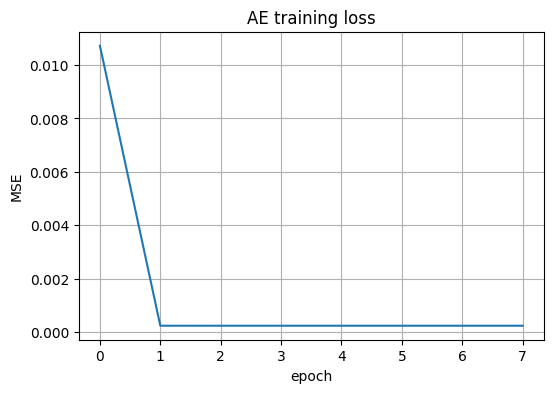

Best train loss: 0.0002475082956606684


In [16]:
#================================================
# Cell 5 — Train (MSE), early stop, save best
#================================================
gc.collect(); torch.cuda.empty_cache()

epochs = 20          # you can raise to 30+ if time allows
lr = 1e-3
opt  = torch.optim.Adam(ae.parameters(), lr=lr)
crit = nn.MSELoss()
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))

best = 1e9
patience, bad = 6, 0
curve = []

for ep in range(1, epochs+1):
    ae.train()
    run = 0.0
    for x in tqdm(train_loader, desc=f"Epoch {ep}/{epochs}"):
        x = x.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            y = ae(x)
            loss = crit(y, x)
        scaler.scale(loss).backward()
        scaler.step(opt); scaler.update()
        run += loss.item()*x.size(0)
    ep_loss = run/len(train_ds)
    curve.append(ep_loss)
    print(f"Epoch {ep} | train MSE={ep_loss:.6f}")
    # early stop on training loss (unsupervised)
    if ep_loss < best - 1e-5:
        best = ep_loss; bad = 0
        torch.save(ae.state_dict(), os.path.join(OUT_DIR, "ae_best.pt"))
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break

plt.figure(figsize=(6,4)); plt.plot(curve); plt.grid(True)
plt.title("AE training loss"); plt.xlabel("epoch"); plt.ylabel("MSE")
plt.savefig(os.path.join(OUT_DIR, "train_loss.png"), dpi=150)
plt.show()

print("Best train loss:", best)


In [17]:
#===============================================================================
# Cell 6 — Score test frames (per-clip error → center frame), smooth, threshold
#=================================================================================
# reload best
ae.load_state_dict(torch.load(os.path.join(OUT_DIR, "ae_best.pt"), map_location=device))
ae.eval()

# step 1: raw scores
raw_scores = []
with torch.no_grad():
    for x in tqdm(test_loader, desc="Scoring"):
        x = x.to(device, non_blocking=True)
        y = ae(x)
        e = torch.mean((y - x)**2, dim=(1,2,3))  # (B,)
        raw_scores.extend(e.detach().cpu().numpy().tolist())

raw_scores = np.array(raw_scores)

# step 2: temporal smoothing (EMA)
def ema(arr, alpha=0.2):
    out = np.zeros_like(arr)
    acc = 0.0
    for i,a in enumerate(arr):
        acc = alpha*a + (1-alpha)*acc if i>0 else a
        out[i] = acc
    return out

scores_ema = ema(raw_scores, alpha=0.2)

# step 3: normalize to [0,1] for readability
def minmax(a):
    m, M = np.min(a), np.max(a)
    return (a - m) / (M - m + 1e-12)

scores_norm = minmax(scores_ema)

# step 4: adaptive threshold (MAD or percentile)
median = np.median(scores_norm)
mad = np.median(np.abs(scores_norm - median)) + 1e-9
thr_mad = float(median + 2.5 * mad)  # tweak k=2.0~3.0
thr_pct = float(np.percentile(scores_norm, 95))

thr = min(1.0, max(0.0, 0.5*thr_mad + 0.5*thr_pct))  # blend
print(f"Threshold (MAD/pct blend): {thr:.4f}")

# save scores
np.save(os.path.join(OUT_DIR, "scores_raw.npy"), raw_scores)
np.save(os.path.join(OUT_DIR, "scores_norm.npy"), scores_norm)
with open(os.path.join(OUT_DIR, "threshold.json"), "w") as f:
    json.dump({"thr": thr}, f)


Scoring: 100%|██████████| 240/240 [00:45<00:00,  5.26it/s]

Threshold (MAD/pct blend): 0.1002


In [18]:
#===================================================
#  Cell 7 — Mark anomaly events, export CSV
#===================================================
# boolean mask
is_anom = scores_norm >= thr

# group into segments
segments = []
start = None
for i,flag in enumerate(is_anom):
    if flag and start is None:
        start = i
    if (not flag or i == len(is_anom)-1) and start is not None:
        end = i if not flag else i
        if end - start + 1 >= 5:  # require ≥5 frames
            segments.append((start, end))
        start = None

import pandas as pd
df = pd.DataFrame({
    "frame_index": np.arange(len(scores_norm)),
    "score": scores_norm,
    "anomaly": is_anom.astype(int)
})
df.to_csv(os.path.join(OUT_DIR, "anomaly_scores.csv"), index=False)
pd.DataFrame(segments, columns=["start_idx","end_idx"]).to_csv(os.path.join(OUT_DIR, "anomaly_segments.csv"), index=False)

print("Saved CSVs to:", OUT_DIR)
print("Found segments:", segments[:10], " ... total:", len(segments))


Saved CSVs to: /kaggle/working/unsup_anomaly/outputs
Found segments: [(931, 1035), (1435, 1446), (2515, 2522), (2647, 2653), (3956, 3970), (4252, 4262), (5113, 5136), (5215, 5232), (5259, 5274), (5282, 5307)]  ... total: 44


In [19]:
#=================================================================
#  Cell 8 — Visualize heatmaps on a few frames (qualitative)
#=================================================================

def heatmap_for_frame(index_in_test_ds):
    # fetch the exact clip input and reconstruction
    # need to rebuild a single sample from dataset
    x = test_ds[index_in_test_ds].unsqueeze(0).to(device)  # (1,K,H,W)
    with torch.no_grad():
        y = ae(x)
    err = (y - x).pow(2).mean(dim=1)[0].cpu().numpy()  # (H,W)
    err = (err - err.min()) / (err.max() - err.min() + 1e-9)
    return (err*255).astype(np.uint8)

sample_ids = list(range(50, 50+6))  # pick some
for idx in sample_ids:
    hmap = heatmap_for_frame(idx)
    # fetch real frame (aligned with dataset index t)
    frame_path = sorted([p for p in os.listdir(FR_TEST) if p.endswith(".jpg")])[K + idx]  # dataset starts at K
    full_path  = os.path.join(FR_TEST, frame_path)
    frame = cv2.imread(full_path)
    heat = cv2.applyColorMap(hmap, cv2.COLORMAP_JET)
    heat = cv2.resize(heat, (frame.shape[1], frame.shape[0]))
    overlay = cv2.addWeighted(frame, 0.6, heat, 0.4, 0)
    outp = os.path.join(OUT_DIR, f"viz_{frame_path}")
    cv2.imwrite(outp, np.hstack([frame, overlay]))

print("Saved heatmap examples to:", OUT_DIR)


Saved heatmap examples to: /kaggle/working/unsup_anomaly/outputs


In [20]:
#====================================================================
#  Cell 9 — Make an MP4 with live anomaly score (no GT)
#=====================================================================
# choose first test video for demo
test_videos = sorted([f for f in os.listdir(TEST_VIDS) if f.lower().endswith((".avi",".mp4",".mov"))])
assert len(test_videos) > 0, "No test videos found."
demo_vid = os.path.join(TEST_VIDS, test_videos[0])
print("Demo video:", demo_vid)

# load threshold & model
with open(os.path.join(OUT_DIR, "threshold.json")) as f:
    thr = json.load(f)["thr"]

cap = cv2.VideoCapture(demo_vid)
fps = cap.get(cv2.CAP_PROP_FPS) or 25
W,H = int(cap.get(3)), int(cap.get(4))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
writer = cv2.VideoWriter(os.path.join(OUT_DIR, "unsup_anomaly_demo.mp4"), fourcc, fps, (W,H))

# sliding buffer of grayscale frames
buf = []

ae.eval()
with torch.no_grad():
    while True:
        ok, frame = cap.read()
        if not ok: break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float32)/255.0
        buf.append(cv2.resize(gray, (224,224)))
        if len(buf) < (K+1):
            writer.write(frame); continue
        if len(buf) > (K+1):
            buf.pop(0)

        stack = np.stack(buf, 0)             # (K+1,H,W)
        diffs = np.abs(stack[1:] - stack[:-1])  # (K,H,W)
        x = torch.from_numpy(diffs).unsqueeze(0).to(device)  # (1,K,H,W)
        y = ae(x)
        mse = torch.mean((y - x)**2).item()

        # normalize roughly based on training stats we saved
        # here we map using min/max of scores_norm for visibility
        # (fallback if you want stable scaling across videos)
        mse_scaled = (mse - np.min(scores_ema)) / (np.max(scores_ema) - np.min(scores_ema) + 1e-9)
        status = "ANOMALY" if mse_scaled >= thr else "OK"
        color  = (0,0,255) if status=="ANOMALY" else (0,200,0)

        cv2.putText(frame, f"Score={mse_scaled:.3f}  Thr={thr:.3f}", (10,30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,255), 2)
        cv2.putText(frame, status, (10,70),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 3)
        writer.write(frame)

cap.release(); writer.release()
print("Saved:", os.path.join(OUT_DIR, "unsup_anomaly_demo.mp4"))


Demo video: /kaggle/input/weapon-dataset/Avenue_Dataset/Avenue Dataset/testing_videos/01.avi
Saved: /kaggle/working/unsup_anomaly/outputs/unsup_anomaly_demo.mp4


In [22]:
#==========================================================================
# Cell 7 — Proper evaluation: PER VIDEO (only compute AUC if 0 and 1 exist)
#==========================================================================

import os, glob
from scipy.io import loadmat
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve
import numpy as np
import matplotlib.pyplot as plt

print("Evaluating PER VIDEO...")
GT_root = TEST_VOLS

# load model scores if not present in variable "scores"
# scores = np.load(os.path.join(OUT_DIR, "scores_norm.npy"))

video_names = sorted(set([os.path.basename(p).split("_")[0] 
                          for p in os.listdir(FR_TEST) if p.endswith(".jpg")]))

auc_results = []

for vid in video_names:
    # ---- Extract scores for this video ----
    frame_paths = sorted([p for p in os.listdir(FR_TEST) if p.startswith(vid) and p.endswith(".jpg")])
    idxs = [int(fp.split("_")[-1].split(".")[0]) for fp in frame_paths]
    
    if len(idxs) == 0: 
        continue

    s = scores[:len(idxs)]    # already in order since datasets were created sequentially
    scores = scores[len(idxs):]  # shift for next video

    # ---- Load GT volume ----
    vol_mat = os.path.join(GT_root, f"vol{vid}.mat")
    if not os.path.exists(vol_mat):
        print(f"⚠️ No GT for video {vid}, skipping")
        continue

    mat = loadmat(vol_mat)
    vol = None
    for k in ("volLabel","volGT","vol","volume"):
        if k in mat:
            vol = mat[k]
            break
    assert vol is not None, f"No GT volume key found in {vol_mat}"
    
    T = vol.shape[-1]
    y_true = np.array([(vol[..., t] > 0).any() for t in range(T)], dtype=int)

    N = min(len(s), len(y_true))
    y_true = y_true[:N]
    y_score = s[:N]

    if len(np.unique(y_true)) < 2:
        print(f"⚠️ Video {vid}: contains only one class → skip AUC")
        continue

    # ---- Compute AUC ----
    roc_auc = roc_auc_score(y_true, y_score)
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    pr_auc = auc(recall, precision)

    auc_results.append((vid, roc_auc, pr_auc))
    print(f"Video {vid} → ROC-AUC={roc_auc:.3f} | PR-AUC={pr_auc:.3f}")

# ---- Print Summary ----
if auc_results:
    roc_mean = np.mean([r[1] for r in auc_results])
    pr_mean = np.mean([r[2] for r in auc_results])
    print("\n====== FINAL RESULTS (Videos with both classes) ======")
    print(f"Mean ROC-AUC: {roc_mean:.4f}")
    print(f"Mean PR-AUC:  {pr_mean:.4f}")
else:
    print("\n❌ No videos contained both 0 and 1 → Cannot compute AUC.")


Evaluating PER VIDEO...
⚠️ Video 01: contains only one class → skip AUC
⚠️ Video 02: contains only one class → skip AUC
⚠️ Video 03: contains only one class → skip AUC
⚠️ Video 04: contains only one class → skip AUC
⚠️ Video 05: contains only one class → skip AUC
⚠️ Video 06: contains only one class → skip AUC
⚠️ Video 07: contains only one class → skip AUC
⚠️ Video 08: contains only one class → skip AUC
⚠️ Video 09: contains only one class → skip AUC
⚠️ Video 10: contains only one class → skip AUC
⚠️ Video 11: contains only one class → skip AUC
⚠️ Video 12: contains only one class → skip AUC
⚠️ Video 13: contains only one class → skip AUC
⚠️ Video 14: contains only one class → skip AUC
⚠️ Video 15: contains only one class → skip AUC
⚠️ Video 16: contains only one class → skip AUC
⚠️ Video 17: contains only one class → skip AUC
⚠️ Video 18: contains only one class → skip AUC
⚠️ Video 19: contains only one class → skip AUC
⚠️ Video 20: contains only one class → skip AUC
⚠️ Video 21: con

In [23]:
from scipy.io import loadmat
import numpy as np, os, glob

GT_root = TEST_VOLS
print("Checking anomaly distribution in GT volumes...\n")

for vid in sorted([vp.split("vol")[-1].split(".")[0] for vp in os.listdir(GT_root) if vp.endswith(".mat")]):
    vol_mat = os.path.join(GT_root, f"vol{vid}.mat")
    mat = loadmat(vol_mat)
    vol = None
    for k in ("volLabel","volGT","vol","volume"):
        if k in mat:
            vol = mat[k]
            break
    if vol is None:
        print(f"{vid} → ❌ no vol key found")
        continue

    T = vol.shape[-1]
    y_true = np.array([(vol[..., t] > 0).any() for t in range(T)], dtype=int)
    unique, counts = np.unique(y_true, return_counts=True)
    print(f"Video {vid}: {dict(zip(unique, counts))}")


Checking anomaly distribution in GT volumes...

Video 01: {1: 1439}
Video 02: {1: 1211}
Video 03: {1: 923}
Video 04: {1: 947}
Video 05: {1: 1007}
Video 06: {1: 1283}
Video 07: {1: 605}
Video 08: {1: 36}
Video 09: {1: 1175}
Video 10: {1: 841}
Video 11: {1: 472}
Video 12: {1: 1271}
Video 13: {1: 549}
Video 14: {1: 507}
Video 15: {1: 1001}
Video 16: {1: 740}
Video 17: {1: 426}
Video 18: {1: 294}
Video 19: {1: 248}
Video 20: {1: 273}
Video 21: {1: 76}


In [24]:
from scipy.io import loadmat
mat = loadmat(os.path.join(TEST_VOLS, "vol01.mat"))

print(mat.keys())
for k, v in mat.items():
    if k.startswith("__"): 
        continue
    print(k, type(v), v.shape if hasattr(v, 'shape') else None)


dict_keys(['__header__', '__version__', '__globals__', 'vol'])
vol <class 'numpy.ndarray'> (120, 160, 1439)


In [25]:
from scipy.io import loadmat
import numpy as np
import os

vp = os.path.join(TEST_VOLS, "vol01.mat")
mat = loadmat(vp)
vol = mat["vol"]  # 120 x 160 x T

print("Min:", vol.min(), "Max:", vol.max())
vals = np.unique(vol)
print("Unique values:", vals[:20], " ... total:", len(vals))


Min: 4 Max: 253
Unique values: [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]  ... total: 250


In [26]:
# Convert vol to frame-level GT using intensity thresholding
vol = vol.astype(float)
T = vol.shape[-1]

# Compute per-frame anomaly score from vol
frame_scores_gt = [vol[..., t].mean() for t in range(T)]

# Make binary GT: anomaly if above mean + 2*std
mu, sigma = np.mean(frame_scores_gt), np.std(frame_scores_gt)
thr_gt = mu + 2 * sigma

frame_labels = np.array([1 if s > thr_gt else 0 for s in frame_scores_gt])
print("GT threshold:", thr_gt, " Positives:", frame_labels.sum(), "/", T)


GT threshold: 101.80371757290617  Positives: 9 / 1439


In [27]:
import numpy as np
from scipy.io import loadmat
import os, glob

vp = sorted(glob.glob(os.path.join(TEST_VOLS, "vol*.mat")))[0]
mat = loadmat(vp)
vol = mat["vol"].astype(float)

means = [vol[..., t].mean() for t in range(vol.shape[-1])]
print("Frame mean stats → min:", np.min(means), "max:", np.max(means), "std:", np.std(means))


Frame mean stats → min: 90.39744791666666 max: 107.48640625 std: 1.6066615285193395
